In [1]:
import json
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras import initializers

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

initializers_list = [
    initializers.RandomNormal,
    initializers.RandomUniform,
    initializers.TruncatedNormal,
    initializers.VarianceScaling,
    initializers.GlorotNormal,
    initializers.GlorotUniform,
    initializers.HeNormal,
    initializers.HeUniform,
    initializers.LecunNormal,
    initializers.LecunUniform,
    initializers.Orthogonal,
]

for initializer in initializers_list:
    print(f"Running {initializer}")

    for iteration in range(2):
        # In order to get same results across multiple runs from an initializer,
        # you can specify a seed value.
        result = float(initializer(seed=42)(shape=(1, 1)))
        print(f"\tIteration --> {iteration} // Result --> {result}")
    print("\n")


Running <class 'keras.src.initializers.initializers.RandomNormal'>
	Iteration --> 0 // Result --> 0.000790853810030967
	Iteration --> 1 // Result --> 0.000790853810030967


Running <class 'keras.src.initializers.initializers.RandomUniform'>
	Iteration --> 0 // Result --> -0.02175668440759182
	Iteration --> 1 // Result --> -0.02175668440759182


Running <class 'keras.src.initializers.initializers.TruncatedNormal'>
	Iteration --> 0 // Result --> 0.000790853810030967
	Iteration --> 1 // Result --> 0.000790853810030967


Running <class 'keras.src.initializers.initializers.VarianceScaling'>
	Iteration --> 0 // Result --> 0.017981600016355515
	Iteration --> 1 // Result --> 0.017981600016355515


Running <class 'keras.src.initializers.initializers.GlorotNormal'>
	Iteration --> 0 // Result --> 0.017981600016355515
	Iteration --> 1 // Result --> 0.017981600016355515


Running <class 'keras.src.initializers.initializers.GlorotUniform'>
	Iteration --> 0 // Result --> -0.7536736726760864
	Iterati

In [2]:
from services.load_dataset import load_data
from services.modeling import run_tuner
import numpy as np



X_train, X_val, X_test, y_train, y_val, y_test  = load_data(data_folder='data')

In [3]:
best_model, best_hp, X_train_final_res, y_train_final_res, X_test_final, y_test_final = run_tuner(
    X_train=np.concatenate((X_train, X_val), axis=0),
    X_test=X_test,
    y_train=np.concatenate((y_train, y_val), axis=0),
    y_test=y_test
)

Trial 10 Complete [00h 24m 39s]
val_recall: 0.6609195470809937

Best val_recall So Far: 0.7403314709663391
Total elapsed time: 02h 29m 02s
Best Model Evaluation on Test Set:
Loss: 0.0319
Accuracy: 0.9944
Precision: 0.5415
Recall: 0.7541
AUC: 0.9077

All Trial Results:
Trial ID: 00, Score: 0.5488505959510803, Hyperparameters: {'sequence_length': 10, 'units_lstm1': 32, 'dropout1': 0.30000000000000004, 'units_lstm2': 32, 'dropout2': 0.5, 'learning_rate': 2.5549654007576828e-06, 'run_time': 715.3604774475098}
Trial ID: 01, Score: 0.6867815852165222, Hyperparameters: {'sequence_length': 10, 'units_lstm1': 32, 'dropout1': 0.30000000000000004, 'units_lstm2': 16, 'dropout2': 0.5, 'learning_rate': 2.9414800463547567e-05, 'run_time': 728.2369453907013}
Trial ID: 02, Score: 0.12481202930212021, Hyperparameters: {'sequence_length': 20, 'units_lstm1': 32, 'dropout1': 0.5, 'units_lstm2': 16, 'dropout2': 0.30000000000000004, 'learning_rate': 7.883914384218181e-07, 'run_time': 1105.2924149036407}
Tria

In [4]:
import pickle
best_model.save('model/base_lstm_model.keras')
pickle.dump(best_hp, open('model/best_hp.pkl', 'wb'))

In [5]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('model/base_lstm_model.keras')

# Check the model architecture
loaded_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 32)             7936      
                                                                 
 dropout (Dropout)           (None, 5, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 32833 (128.25 KB)
Trainable params: 32833 (128.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
from services.modeling import *
from keras_tuner.engine.hyperparameters import HyperParameters

hypermodel = LSTMHyperModel(X_train=X_train, labels=y_train)
# Load the tuner results
tuner = kt.RandomSearch(
    hypermodel,
    objective=kt.Objective('val_recall', direction='max'),
    max_trials=10,         # Increase for a more thorough search
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='credit_card_fraud_lstm_precision'
)

# Load the search results
tuner.reload()

# Extract trial results
trials = tuner.oracle.trials

# Collect val_recall, val_precision, and compute F1 score
f1_results = []
for trial_id, trial in trials.items():
    val_recall = trial.metrics.get_history("val_recall")[-1].value[0]  # Get the last recorded val_recall
    val_precision = trial.metrics.get_history("val_precision")[-1].value[0]  # Get the last recorded val_precision
    
    # Compute F1 score
    f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall + 1e-7)  # Add small epsilon to avoid division by zero
    
    f1_results.append({
        "trial_id": trial_id,
        "f1_score": f1_score,
        "val_recall": val_recall,
        "val_precision": val_precision,
        "hyperparameters": trial.hyperparameters.values
    })

# Sort trials by F1 score (descending order)
f1_results.sort(key=lambda x: x["f1_score"], reverse=True)

# Get the best trial based on F1 score
best_trial = f1_results[0]
print("Best Trial Based on F1 Score:")
print(f"Trial ID: {best_trial['trial_id']}")
print(f"F1 Score: {best_trial['f1_score']}")
print(f"val_recall: {best_trial['val_recall']}")
print(f"val_precision: {best_trial['val_precision']}")
print(f"Hyperparameters: {best_trial['hyperparameters']}")

# Convert the best hyperparameters dictionary to a HyperParameters object
best_hp_dict = best_trial["hyperparameters"]
best_hp = HyperParameters()
best_hp.values = best_hp_dict

# Build the model using the HyperParameters object
best_model = tuner.hypermodel.build(best_hp)

Reloading Tuner from hyperparam_tuning\credit_card_fraud_lstm_precision\tuner0.json
Best Trial Based on F1 Score:
Trial ID: 04
F1 Score: 0.6792452633599452
val_recall: 0.5966851115226746
val_precision: 0.7883211970329285
Hyperparameters: {'sequence_length': 5, 'units_lstm1': 128, 'dropout1': 0.4, 'units_lstm2': 32, 'dropout2': 0.1, 'learning_rate': 1.3689316316414068e-06}


In [7]:
from services.modeling import create_sequences

best_seq_length = best_hp.get('sequence_length')
X_t, y_t = np.concatenate((X_train, X_val), axis=0), np.concatenate((y_train, y_val), axis=0)
# For final evaluation, generate a test set using the best sequence length.
X_train_final, y_train_final = create_sequences(X_t, y_t, best_seq_length)
X_test_final, y_test_final = create_sequences(X_test, y_test, best_seq_length)

# Apply SMOTE on the training set
n_samples, seq_len, n_features_local = X_train_final.shape
X_train_final_flat = X_train_final.reshape(n_samples, seq_len * n_features_local)
smote = SMOTE(random_state=42, sampling_strategy=0.25)
X_train_final_res, y_train_final_res = smote.fit_resample(X_train_final_flat, y_train_final)
X_train_final_res = X_train_final_res.reshape(-1, best_seq_length, n_features_local)

# Retrieve the best model and evaluate on the test set
loss, accuracy, precision, recall, auc_metric = best_model.evaluate(X_test_final, y_test_final, verbose=0)
print("Best Model Evaluation on Test Set:")
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc_metric:.4f}")


# -----------------------------------------#
# 5. Print All Trials and Best Parameters  #
# -----------------------------------------#

print("\nAll Trial Results:")
for trial in tuner.oracle.trials.values():
    # print f1_score
    val_recall = trial.metrics.get_history("val_recall")[-1].value[0]  # Get the last recorded val_recall
    val_precision = trial.metrics.get_history("val_precision")[-1].value[0]  # Get the last recorded val_precision
    f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall + 1e-7)  # Add small epsilon to avoid division by zero
    print(f"Trial ID: {trial.trial_id}, Score: {f1_score}, Hyperparameters: {trial.hyperparameters.values}")

print("\nBest Hyperparameters:")
print(best_hp.values)


NameError: name 'SMOTE' is not defined

In [24]:
best_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 128)            80896     
                                                                 
 dropout_6 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 101537 (396.63 KB)
Trainable params: 101537 (396.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2380/2380 [==============================] - 13s 6ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

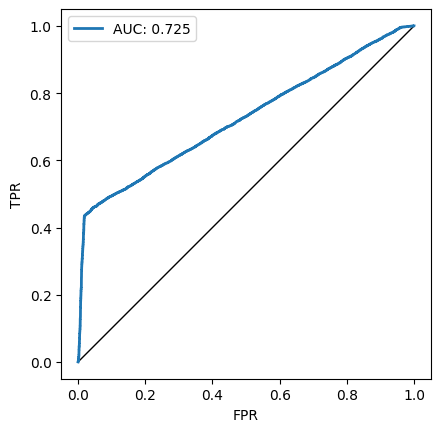

In [8]:
from services.eval_privacy import compute_mia_attacks

attacks_results, fig = compute_mia_attacks(model=best_model, X_train=X_train_final_res, X_test=X_test_final, y_train=y_train_final_res, y_test=y_test_final)

In [19]:
import pandas as pd

pd.set_option("display.max_rows", 8, "display.max_columns", None)
print(attacks_results.calculate_pd_dataframe())

           slice feature slice value  train size  test size  \
0         Entire dataset                  252487      76137   
1         Entire dataset                  252487      76137   
2                  class           0      201990      74280   
3                  class           0      201990      74280   
..                   ...         ...         ...        ...   
26  correctly_classified        True      201990      74280   
27  correctly_classified        True      201990      74280   
28  correctly_classified       False       50497       1857   
29  correctly_classified       False       50497       1857   

            attack type  Attacker advantage  Positive predictive value  \
0      THRESHOLD_ATTACK            0.360897                   0.951030   
1   LOGISTIC_REGRESSION            0.402566                   0.972704   
2      THRESHOLD_ATTACK            0.330837                   0.972250   
3   LOGISTIC_REGRESSION            0.330992                   0.971528   